In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
from matplotlib.cm import get_cmap
import matplotlib.ticker as ticker
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap

In [2]:
import warnings
warnings.simplefilter(action='ignore')

In [3]:
pd.set_option('display.max_columns', None)
pd.reset_option('display.max_rows', None)

In [4]:
df = pd.read_csv("b2b_updated_final4.csv")
df_player = pd.read_csv("player_performance_data.csv")
df_team = pd.read_csv("team_data_updated.csv")

In [5]:
df_test = df_player.groupby(['season', 'team', 'Player']).sum().reset_index()

In [6]:
df_test.head(5)

,season,team,Player,Unnamed: 0,Rk,G,A,PTS,+/-,PIM,EV,EV.1,PP,PP.1,SH,SH.1,GW,EV.2,EV.3,PP.2,PP.3,SH.2,SH.3,S,S%,SHFT,TOI,iCF,SAT‑F,SAT‑A,CF%,CRel%,ZSO,ZSD,oZS%,HIT,BLK,is_b2b_game,is_3in4_game,is_5in8_game
0,20102011,Anaheim Ducks,Aaron Voros,6154803,216.0,0.0,0.0,0,-4.0,43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,116.0,66.550000,10.0,53,61,564.1,329.6,26.0,15.0,674.4,12,1.0,4,4,4
1,20102011,Anaheim Ducks,Andreas Lilja,27213158,371.0,1.0,6.0,7,-15.0,28,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,50.0,1180.0,906.516667,60.0,526,1061,1794.6,370.1,184.0,361.0,1794.9,92,113.0,5,5,5
2,20102011,Anaheim Ducks,Andy Sutton,20466206,656.0,0.0,4.0,4,1.0,87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0,732.0,575.383333,51.0,362,674,1394.3,539.9,130.0,184.0,1661.8,62,87.0,5,5,5
3,20102011,Anaheim Ducks,Bobby Ryan,43023295,1131.0,34.0,37.0,71,15.0,61,28.0,0.0,5.0,0.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,270.0,929.8,2105.0,1654.733333,421.0,1597,1521,4192.3,2356.5,505.0,318.0,4944.7,156,34.0,10,10,10
4,20102011,Anaheim Ducks,Brad Winchester,10310148,342.0,1.0,1.0,2,-9.0,28,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,20.0,290.0,198.866667,33.0,146,185,832.7,292.0,54.0,46.0,1063.1,51,7.0,2,2,2


In [9]:
#Highest Points getter for each team
grouped = df_test.groupby(['team', 'Player']).agg({'PTS': 'sum'}).reset_index()

idx = grouped.groupby(['team'])['PTS'].transform(max) == grouped['PTS']
highest_scorers = grouped[idx]

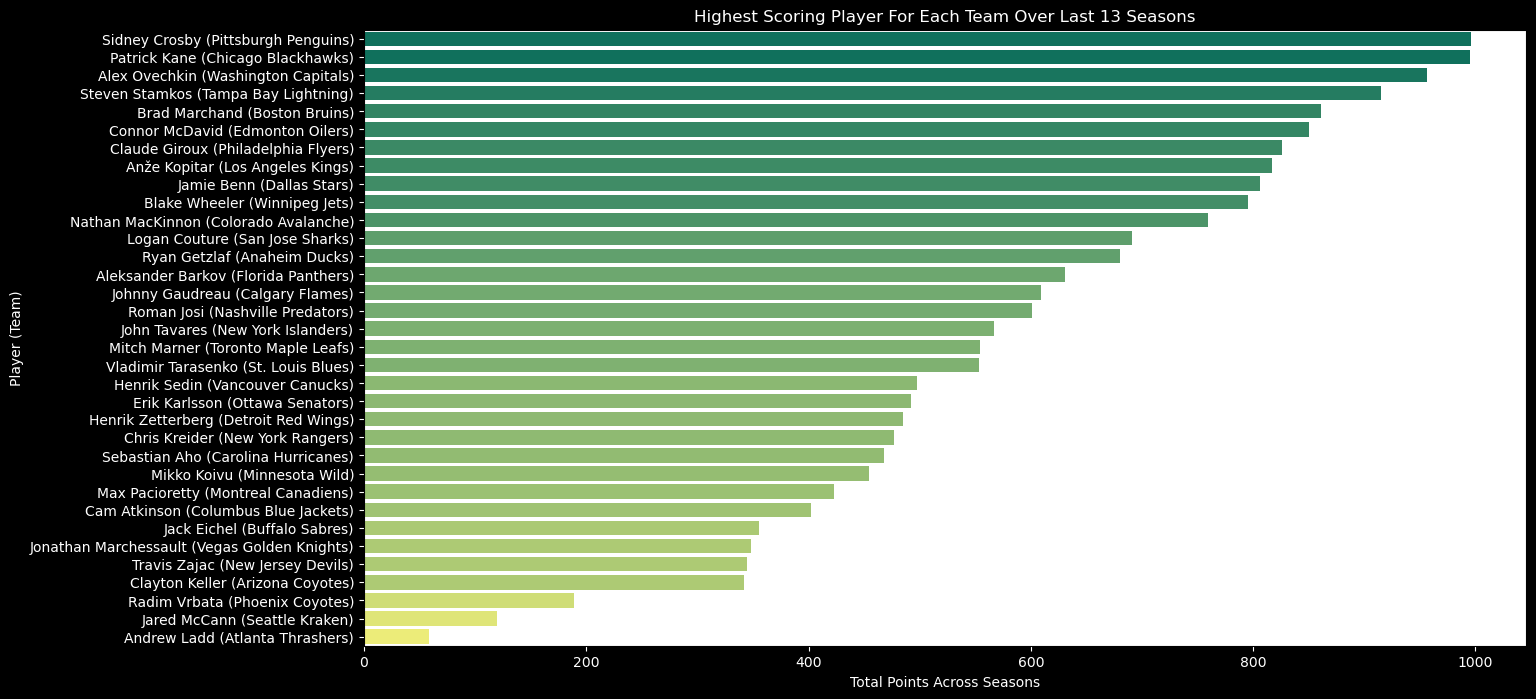

In [14]:
highest_scorers = highest_scorers.sort_values(by = 'PTS', ascending = False)

highest_scorers['Player_team'] = highest_scorers['Player'] + " (" + highest_scorers['team'] + ")"

norm = Normalize(highest_scorers['PTS'].min(), highest_scorers['PTS'].max())
cmap = get_cmap("summer_r")
highest_scorers['color'] = highest_scorers['PTS'].apply(lambda x: cmap(norm(x)))

fig = plt.figure(figsize=(15, 8))
fig.patch.set_facecolor('black')
sns.barplot(x='PTS', y='Player_team', 
            data=highest_scorers, 
            palette=highest_scorers['color'], 
            orient='h')

plt.ylabel('Player (Team)', color='#ffffff')
plt.xlabel('Total Points Across Seasons', color='#ffffff')
plt.title('Highest Scoring Player For Each Team Over Last 13 Seasons', color='#ffffff')

ax = plt.gca()  # get current axis
ax.tick_params(axis='x', colors='#FFFFFF')
ax.tick_params(axis='y', colors='#FFFFFF')
ax.xaxis.label.set_color('#FFFFFF')
ax.yaxis.label.set_color('#FFFFFF')

# Weighted Score

In [15]:
weights = {
    'G': 2,
    'A': 1.5,
    '+/-': 1.5,
    'CF%': 1,
}

# 1. Sum stats for each player in each season
grouped = df_player.groupby(['season', 'team', 'Player']).agg({
    'G': 'sum',
    'A': 'sum',
    '+/-': 'sum',
    'CF%': 'mean',
}).reset_index()

grouped['weighted_score'] = grouped['G'] * weights['G'] + \
                            grouped['A'] * weights['A'] + \
                            grouped['+/-'] * weights['+/-'] + \
                            grouped['CF%'] * weights['CF%'] 

In [17]:
grouped['PTS'] = grouped['G'] + grouped['A']
top_players = grouped.groupby(['season', 'team']).apply(lambda x: x.nlargest(1, 'PTS')).reset_index(drop=True)
top_players23 = top_players[top_players['season'] == 20222023]

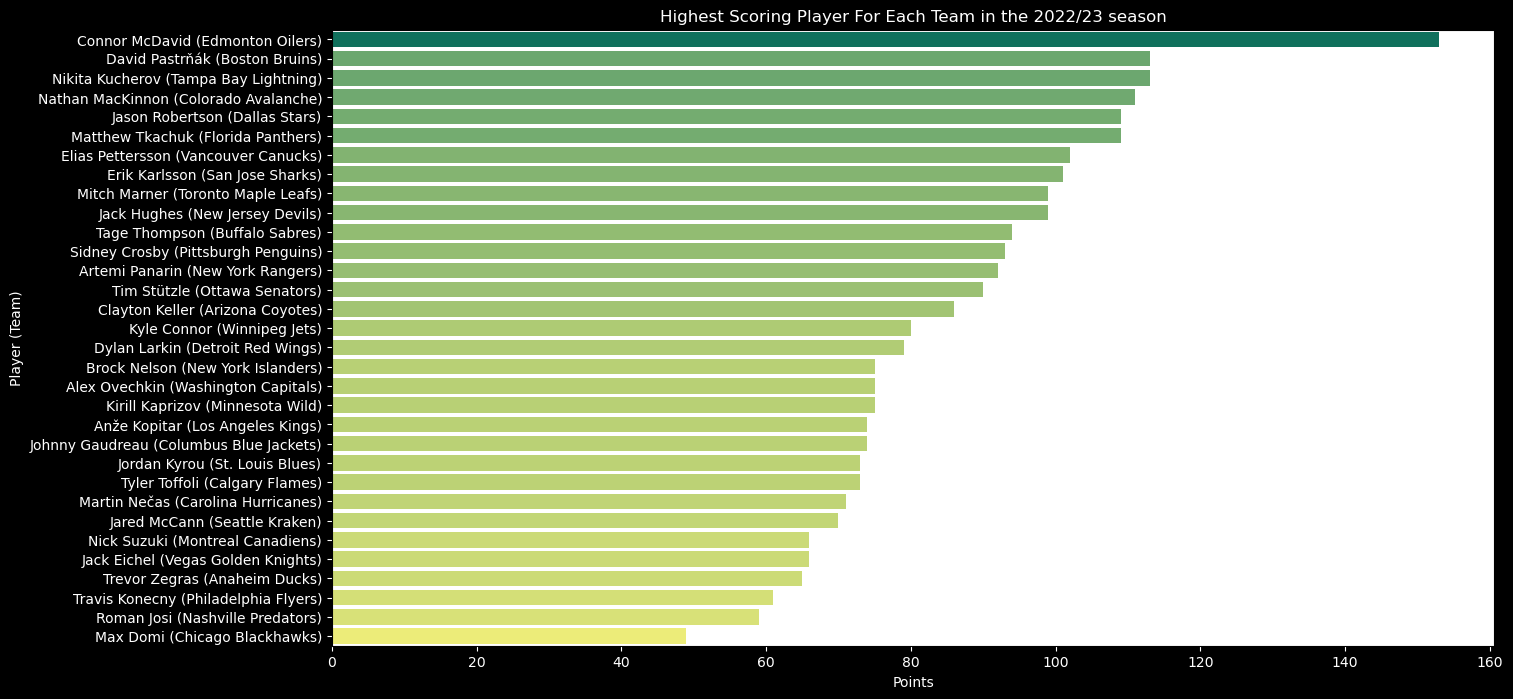

In [19]:
df_top10 = top_players23.copy()
df_top10 = df_top10.sort_values(by = 'PTS', ascending = False)
df_top10['Player_team'] = df_top10['Player'] + " (" + df_top10['team'] + ")"
norm = Normalize(df_top10['PTS'].min(), df_top10['PTS'].max())
cmap = get_cmap("summer_r")
df_top10['color'] = df_top10['PTS'].apply(lambda x: cmap(norm(x)))

fig = plt.figure(figsize=(15, 8))
fig.patch.set_facecolor('black')
sns.barplot(x='PTS', y='Player_team', 
            data=df_top10, 
            palette= df_top10['color'], 
            orient = 'h')

plt.ylabel('Player (Team)', color = '#ffffff')
plt.xlabel('Points', color = '#ffffff')
plt.title('Highest Scoring Player For Each Team in the 2022/23 season', color = '#ffffff')

ax = plt.gca()  # get current axis
ax.tick_params(axis='x', colors='#FFFFFF')
ax.tick_params(axis='y', colors='#FFFFFF')
ax.xaxis.label.set_color('#FFFFFF')
ax.yaxis.label.set_color('#FFFFFF')
#plt.xticks(
        #rotation = 45, 
        #horizontalalignment = 'right',
        #fontweight = 'light',
        #fontsize = 'medium'
    #) # Rotate x-axis labels for better visibility